In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

from models import GPT

In [2]:
# global parameters
BATCH_SIZE = 16
CONTEXT_SIZE = 32
EPOCH = 1000000

LOG_INTERVAL = 100

In [3]:
# setting up datasets
# we use TinyShakespeare, the collection of all of Shakespeare's works
# that has about 1 million characters

path = "./tinyshakespeare.txt"

lines = open(path,"r").read()
print(f"{len(lines)} characters in the dataset")

# 今回は文字単位でvocablaryを作る
vocab = sorted(list(set(lines)))

itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(f"{len(vocab)} unique characters in the dataset")

1115393 characters in the dataset
65 unique characters in the dataset


In [4]:
# simple tokenizer
def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

e = encode("hello")
print(e)
print(decode(e))

[46, 43, 50, 50, 53]
hello


In [5]:
# create tokenized dataset
dataset = torch.tensor(encode(lines),dtype=torch.int8)
dataset = dataset[:3000]
print(dataset.shape)

torch.Size([3000])


In [6]:
def get_batches(data,split,batch_size,context_window):
    train = data[:int(.8*len(data))]
    val = data[int(.8*len(data)):int(.9*len(data))]
    test = data[int(.9*len(data)):]

    if split == "val":
        batch_data = val
    elif split == "test":
        batch_data = test
    else:
        batch_data = train
    
    # pick random starting points
    sp = torch.randint(0,batch_data.size(0) - context_window - 1,(batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in sp]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in sp]).long()

    return x,y

xs,ys = get_batches(dataset,"train",batch_size=2,context_window=10)
print(xs.shape)
print(ys.shape)
print(xs)
print(ys)

print([(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))])

torch.Size([2, 10])
torch.Size([2, 10])
tensor([[ 1, 58, 46, 43,  1, 41, 47, 58, 63,  0],
        [ 1, 46, 59, 52, 45, 43, 56,  1, 44, 53]])
tensor([[58, 46, 43,  1, 41, 47, 58, 63,  0, 47],
        [46, 59, 52, 45, 43, 56,  1, 44, 53, 56]])
[(' the city\n', 'the city\ni'), (' hunger fo', 'hunger for')]


In [7]:
# 評価用のutil関数ども
# モデルの損失を確認する関数

@torch.no_grad()
def evaluate_loss(model,use_cuda=False):
    if use_cuda:
        model = model.cuda()
    out = {}
    model.eval()
    for split in ["train","val"]:
        losses = []
        for _ in range(10):
            xb,yb = get_batches(dataset,split,batch_size=BATCH_SIZE,context_window=CONTEXT_SIZE)
            if use_cuda:
                xb,yb = xb.cuda(),yb.cuda()
            _, loss = model(xb,yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

def evaluate_text(model,xs,ys):
    model.eval()
    preds = model(xs)
    if type(preds) == tuple:
        preds = preds[0]
    preds = preds.argmax(dim=-1)
    model.train()
    return [(decode(xs[i].tolist()), decode(ys[i].tolist()), decode(preds[i].tolist())) for i in range(len(xs))]

In [8]:
class SimpleModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, 64)
        self.linear = nn.Linear(64, vocab_size)
        
    def forward(self,x,targets=None,debug=False):
        if debug: print(f"input shape: {x.shape}")
        x = self.emb(x)
        if debug: print(f"embedding shape: {x.shape}")
        x = self.linear(x)
        if debug: print(f"linear shape: {x.shape}")
        logits = F.softmax(x,dim=-1)

        if targets is not None:
            if debug: 
                print(f"logits view shape: {logits.view(-1,self.vocab_size).shape}")
                print(f"targets view shape: {targets.view(-1).shape}")
            loss = F.cross_entropy(logits.view(-1,self.vocab_size),targets.view(-1))
            return logits, loss
        else:
            return logits
    
    @torch.no_grad()
    def generate(self,idx,max_new_tokens):
        self.eval()
        for _ in range(max_new_tokens):
            if idx.size(1) < CONTEXT_SIZE:
                idx = idx[:,-CONTEXT_SIZE:]
            x = idx.clone().detach().view(1,-1)
            y = self(x)

            idx_next = y.argmax(-1)[:,-1]
            idx_next = idx_next.unsqueeze(-1).clone().detach()
            idx = torch.cat((idx,idx_next),dim=1)

        return idx
        
test_model = SimpleModel(len(vocab))
xs,ys = get_batches(dataset,"train",batch_size=2,context_window=10)

logits, loss = test_model(xs,ys,debug=True)
print(logits.shape)
print(loss)

input shape: torch.Size([2, 10])
embedding shape: torch.Size([2, 10, 64])
linear shape: torch.Size([2, 10, 65])
logits view shape: torch.Size([20, 65])
targets view shape: torch.Size([20])
torch.Size([2, 10, 65])
tensor(4.1753, grad_fn=<NllLossBackward0>)


In [9]:
def train(model, optimizer, scheduler=None, print_logs=False, use_cuda=False):
    if use_cuda:
        model = model.cuda()
    losses = []
    start_time = time.time()
    for epoch in range(EPOCH):
        xs,ys = get_batches(dataset,"train",batch_size=BATCH_SIZE,context_window=CONTEXT_SIZE)
        if use_cuda:
            xs = xs.cuda()
            ys = ys.cuda()
        logits, loss = model(xs,targets=ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        if epoch % LOG_INTERVAL == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model,use_cuda=use_cuda)
            losses.append(x)
            if print_logs:
                print(f"epoch: {epoch}, train loss: {x['train']}, val loss: {x['val']}, ETA in seconds: {batch_time*(EPOCH-epoch)/LOG_INTERVAL:.3f}")

    print("validation loss: ",losses[-1]["val"])
    return losses

model = SimpleModel(len(vocab))
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
losses = train(model,optimizer,print_logs=True)

epoch: 0, train loss: 4.173341131210327, val loss: 4.174221467971802, ETA in seconds: 193.338
epoch: 100, train loss: 4.0263324737548825, val loss: 4.061368322372436, ETA in seconds: 981.481
epoch: 200, train loss: 3.954658031463623, val loss: 4.001058220863342, ETA in seconds: 1715.641
epoch: 300, train loss: 3.944222640991211, val loss: 3.9827446699142457, ETA in seconds: 2470.012
epoch: 400, train loss: 3.9051242113113402, val loss: 3.9618775606155396, ETA in seconds: 3211.832
epoch: 500, train loss: 3.8899839162826537, val loss: 3.9484106302261353, ETA in seconds: 3954.402
epoch: 600, train loss: 3.9059818029403686, val loss: 3.953130102157593, ETA in seconds: 4709.497
epoch: 700, train loss: 3.902489447593689, val loss: 3.9500710725784303, ETA in seconds: 5455.835
epoch: 800, train loss: 3.898013782501221, val loss: 3.943277668952942, ETA in seconds: 6198.507
epoch: 900, train loss: 3.9045109510421754, val loss: 3.947786545753479, ETA in seconds: 6956.059
epoch: 1000, train loss: 

<Axes: >

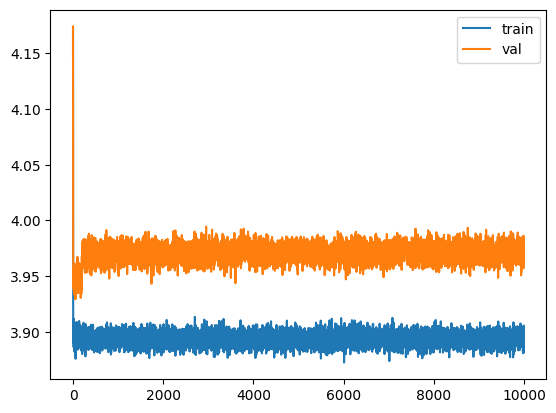

In [10]:
pd.DataFrame(losses).plot()

In [11]:
xs,ys = get_batches(dataset,"test",batch_size=BATCH_SIZE,context_window=CONTEXT_SIZE)
evaluate_text(model,xs,ys)

[('ay as well\nStrike at the heaven ',
  'y as well\nStrike at the heaven w',
  't tt te ll\ne  t  tt t e te te :t'),
 ('icians of you. For your wants,\nY',
  'cians of you. For your wants,\nYo',
  'tott: tuot us\ntiu t us tet:   \no'),
 (' charitable care\nHave the patric',
  'charitable care\nHave the patrici',
  'toet t tel tot  \nete t e tet  to'),
 ('ll\nStrike at the heaven with you',
  'l\nStrike at the heaven with your',
  'll\ne  t  tt t e te te :tet et us'),
 ('t them\nAgainst the Roman state, ',
  ' them\nAgainst the Roman state, w',
  ' t e e\nlott:  t e teuet:t  t   t'),
 ('f you. For your wants,\nYour suff',
  ' you. For your wants,\nYour suffe',
  'ot us\ntiu t us tet:   \nous t soo'),
 ('hose course will on\nThe way it t',
  'ose course will on\nThe way it ta',
  'eu  tous   tetlltu:\nhe tet tt t '),
 ('st the Roman state, whose course',
  't the Roman state, whose course ',
  '  t e teuet:t  t   teeu  tous   '),
 ('ants,\nYour suffering in this dea',
  'nts,\nYour suff

In [12]:
xs,ys = get_batches(dataset,"train",batch_size=BATCH_SIZE,context_window=CONTEXT_SIZE)
evaluate_text(model,xs,ys)

[('it be done: away, away!\n\nSecond ',
  't be done: away, away!\n\nSecond C',
  't te t u: \nttet  ttet \n\n\ne ou: t'),
 ('tizen:\nConsider you what service',
  'izen:\nConsider you what services',
  ' te :\n\niu: t   t usteet t   eto '),
 ('cians good.\nWhat authority surfe',
  'ians good.\nWhat authority surfei',
  'ott: touu \n\nhet tts eu t  t s o '),
 ('n no way say he is covetous.\n\nFi',
  ' no way say he is covetous.\n\nFir',
  ':t:utet t t te tt toue  us \n\n\nit'),
 ('er, hear me speak.\n\nAll:\nSpeak, ',
  'r, hear me speak.\n\nAll:\nSpeak, s',
  '   te t te t e t \n\n\nlll\n\nee t  t'),
 (' till the altitude of his virtue',
  'till the altitude of his virtue.',
  't tllt e ttl t s  tuotet tet  s '),
 (' loved\nthe people.\n\nFirst Citize',
  'loved\nthe people.\n\nFirst Citizen',
  'tlue  \n e te uel \n\n\nit   tit te '),
 ('himself with being proud.\n\nSecon',
  'imself with being proud.\n\nSecond',
  'ete  lotet ete t:ote us \n\n\ne ou:'),
 ('e? to the Capitol!\n\nAll:

In [13]:
x_train,_ = get_batches(dataset,"train",batch_size=1,context_window=CONTEXT_SIZE)
x_val,_ = get_batches(dataset,"val",batch_size=1,context_window=CONTEXT_SIZE)

print(decode(x_train[0].tolist()))
#print(decode(x_val[0].tolist()))
pred_sentence = model.generate(x_train,max_new_tokens=100)
print(decode(pred_sentence.tolist()[0]))

d rather to die than to famish?

d rather to die than to famish?







































































































In [14]:
from models import PositionalEmbedding, GPTBlocks
class GPT(nn.Module):
    def __init__(self, max_seq_len: int, vocab_size: int, num_blocks: int,
                 embed_dim: int, num_heads: int, ff_hidden_dim: int, dropout: float):
        """
        Args:
            max_seq_len (int): 入力系列の最大長
            vocab_size (int): 語彙数
            embed_dim (int): 埋め込み次元数
            num_blocks (int): TransformerBlockの数
            num_heads (int): MultiHeadAttentionのHead数
            ff_hidden_dim (int): FeedForward Networkの隠れ層次元数
            dropout (float): ドロップアウト確率
        """
        super(GPT,self).__init__()
        self.max_seq_len = max_seq_len

        self.embedding_layer = nn.Embedding(vocab_size,embed_dim)
        self.positional_embedding = PositionalEmbedding(max_seq_len,embed_dim)
        self.dropout = nn.Dropout(p=dropout)

        self.blocks = nn.ModuleList([
            GPTBlocks(embed_dim=embed_dim,num_heads=num_heads,ff_hidden_dim=ff_hidden_dim,dropout=dropout)
            for _ in range(num_blocks)
        ])
        
        self.head = nn.Linear(embed_dim,vocab_size) # embeddingの逆行列を使う方法もある
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self,x,targets=None):
        """
        Args:
            x (torch.Tensor): 入力トークン (batch_size,seq_len)
            target (torch.Tensor): 教師トークン (batch_size,seq_len)
        Returns:
            tuple[torch.Tensor, torch.Tensor]: GPTの出力 (batch_size,seq_len,vocab_size), 損失 (1,)
        """
        x = self.embedding_layer(x)
        x = self.positional_embedding(x)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        x = self.softmax(x)

        if targets is not None:
            loss = nn.functional.cross_entropy(x.view(-1,x.size(-1)),targets.view(-1))
            return x,loss
        else:
            return x,None
    
    @torch.no_grad()
    def generate(self,idx,max_new_tokens,temperature=1.0):
        """
        Args:
            idx (list[int]): 入力トークンのリスト
            max_new_tokens (int): 生成するトークン数
            temperature (float): softmaxの温度
        Returns:
            list[int]: 生成されたトークンのリスト
        TODO:
            ちゃんと実装する
        """
        self.eval()
        for _ in range(max_new_tokens):
            if idx.size(1) > self.max_seq_len:
                idx = idx[:,-self.max_seq_len:]
            x = idx.clone().detach().view(1,-1)
            y,_ = self(x)
            idx_next = y.argmax(-1)[:,-1]
            idx_next = idx_next.unsqueeze(-1).clone().detach()
            idx = torch.cat((idx,idx_next),dim=1)

        return idx

In [19]:
# GPT model
## Param
num_blocks = 2
embed_dim = 128
num_heads = 8
ff_hidden_dim = embed_dim*4
dropout = 0.

lr = 3e-4

model = GPT(max_seq_len=64,vocab_size=len(vocab),num_blocks=num_blocks,embed_dim=embed_dim,
            num_heads=num_heads,ff_hidden_dim=ff_hidden_dim,dropout=dropout)

#optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,betas=(0.9,0.95),weight_decay=0.)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=1000,eta_min=lr*0.1)
losses = train(model,optimizer,scheduler,print_logs=True,use_cuda=True)

epoch: 0, train loss: 4.04306697845459, val loss: 4.06845440864563, ETA in seconds: 58.410
epoch: 100, train loss: 4.0549702644348145, val loss: 4.0676655769348145, ETA in seconds: 5539.733
epoch: 200, train loss: 4.051649951934815, val loss: 4.071181201934815, ETA in seconds: 10301.415
epoch: 300, train loss: 4.055556201934815, val loss: 4.071767139434814, ETA in seconds: 15021.506
epoch: 400, train loss: 4.052235889434814, val loss: 4.065321826934815, ETA in seconds: 20034.012
epoch: 500, train loss: 4.051845264434815, val loss: 4.072939014434814, ETA in seconds: 25643.219
epoch: 600, train loss: 4.046767139434815, val loss: 4.070009326934814, ETA in seconds: 30995.998
epoch: 700, train loss: 4.053603076934815, val loss: 4.0686421394348145, ETA in seconds: 37018.503
epoch: 800, train loss: 4.0598530769348145, val loss: 4.062001514434814, ETA in seconds: 42383.409
epoch: 900, train loss: 4.0500874519348145, val loss: 4.068056201934814, ETA in seconds: 47831.771
epoch: 1000, train loss

<Axes: >

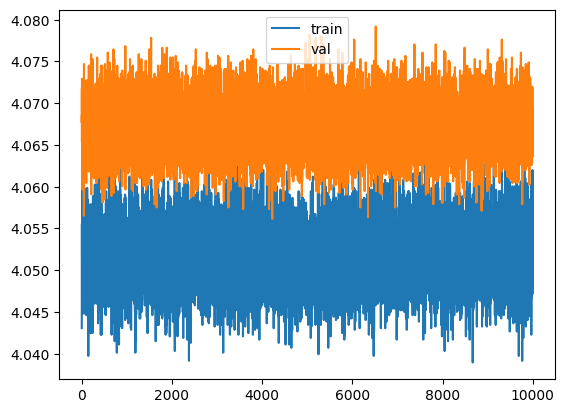

In [20]:
pd.DataFrame(losses).plot()

In [21]:
model.cpu()
xs,ys = get_batches(dataset,"test",batch_size=BATCH_SIZE,context_window=CONTEXT_SIZE)
evaluate_text(model,xs,ys)

[('ke at the heaven with your stave',
  'e at the heaven with your staves',
  '                                '),
 ('with your staves as lift them\nAg',
  'ith your staves as lift them\nAga',
  '                                '),
 ('cracking ten thousand curbs\nOf m',
  'racking ten thousand curbs\nOf mo',
  '                                '),
 ('f more strong link asunder than ',
  ' more strong link asunder than c',
  '                                '),
 ('or your wants,\nYour suffering in',
  'r your wants,\nYour suffering in ',
  '                                '),
 ('hem\nAgainst the Roman state, who',
  'em\nAgainst the Roman state, whos',
  '                                '),
 (' your wants,\nYour suffering in t',
  'your wants,\nYour suffering in th',
  '                                '),
 ('ve the patricians of you. For yo',
  'e the patricians of you. For you',
  '                                '),
 ('iends, most charitable care\nHave',
  'ends, most charitable care\n

In [22]:
x_train,_ = get_batches(dataset,"train",batch_size=1,context_window=CONTEXT_SIZE)
x_val,_ = get_batches(dataset,"val",batch_size=1,context_window=CONTEXT_SIZE)

print(decode(x_train[0].tolist()))
#print(decode(x_val[0].tolist()))
pred_sentence = model.generate(x_train,max_new_tokens=100)
print(decode(pred_sentence.tolist()[0]))

ide o' the city
is risen: why st
                                                                 


In [82]:
# 学習が上手くいってない？ので勾配を確認する
def show_grads(model,tol=1e-4):
    for name,param in model.named_parameters():
        value = 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())
        print(name,param.grad.abs().mean())
        print(name,value)
        # if param.grad is not None:
        #     if param.grad.abs().mean() > tol:
        #         print(name,param.grad.abs().mean())

show_grads(model)

embedding_layer.weight tensor(6.6011e-05)
embedding_layer.weight 0.01201923076923077
blocks.0.mmhsa.query.weight tensor(0.0008)
blocks.0.mmhsa.query.weight 0.15869140625
blocks.0.mmhsa.query.bias tensor(6.4163e-05)
blocks.0.mmhsa.query.bias 0.0
blocks.0.mmhsa.key.weight tensor(0.0009)
blocks.0.mmhsa.key.weight 0.09765625
blocks.0.mmhsa.key.bias tensor(5.8326e-10)
blocks.0.mmhsa.key.bias 0.0
blocks.0.mmhsa.value.weight tensor(0.0057)
blocks.0.mmhsa.value.weight 0.09765625
blocks.0.mmhsa.value.bias tensor(0.0005)
blocks.0.mmhsa.value.bias 0.0
blocks.0.mmhsa.projection.0.weight tensor(0.0027)
blocks.0.mmhsa.projection.0.weight 0.140380859375
blocks.0.mmhsa.projection.0.bias tensor(0.0006)
blocks.0.mmhsa.projection.0.bias 0.0
blocks.0.ff.linear1.weight tensor(0.0050)
blocks.0.ff.linear1.weight 0.09613037109375
blocks.0.ff.linear1.bias tensor(0.0004)
blocks.0.ff.linear1.bias 0.0
blocks.0.ff.linear2.weight tensor(0.0054)
blocks.0.ff.linear2.weight 0.2227783203125
blocks.0.ff.linear2.bias ten

In [83]:
# sentence piece tokenizer
import sentencepiece as spm
#spm.SentencePieceTrainer.Train('--input=tinyshakespeare.txt --model_prefix=m --vocab_size=500 --character_coverage=1.0 --model_type=bpe')
spm.SentencePieceTrainer.train(
    input='tinyshakespeare.txt',
    model_prefix='m',
    vocab_size=500,
    character_coverage=1.0,
    model_type='bpe',
    pad_id=3,
    pad_piece='<pad>',
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: tinyshakespeare.txt
  input_format: 
  model_prefix: m
  model_type: BPE
  vocab_size: 500
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differe

In [84]:
# vocabの確認
sp = spm.SentencePieceProcessor()
sp.Load("m.model")
print(sp.GetPieceSize())
for i in range(sp.GetPieceSize()):
    print(sp.IdToPiece(i))
#print(sp.IdToPiece(0))

500
<unk>
<s>
</s>
<pad>
▁t
he
▁a
ou
▁s
▁m
▁w
in
re
ha
▁the
nd
▁b
is
or
▁f
▁I
er
ll
it
on
▁d
▁c
▁n
▁l
▁y
es
en
▁th
ar
▁h
▁o
▁to
▁you
▁p
▁T
hat
▁A
▁he
st
ve
ot
▁and
ow
ing
▁of
an
om
▁g
at
▁be
▁W
se
▁my
▁in
▁ha
ce
le
ay
ld
ir
et
ed
ut
▁B
▁me
im
▁S
ith
▁not
▁H
ch
▁that
▁is
▁M
gh
▁And
▁for
▁u
ke
▁C
▁we
our
oo
ill
▁e
▁with
her
▁it
ent
▁your
ad
ri
▁O
▁thou
▁st
▁k
▁L
ome
▁his
▁F
▁G
ght
EN
ord
▁re
id
ra
▁The
▁have
▁him
IN
ly
▁li
as
▁P
▁this
ur
IO
al
▁so
▁as
▁de
▁on
▁R
ore
ro
▁N
hi
ould
ood
AR
ck
ain
ver
▁Y
est
▁sha
▁thy
ess
▁will
▁do
ea
▁no
am
▁E
▁but
▁D
us
▁se
US
if
▁'
ge
▁all
and
▁Th
▁su
ake
▁To
▁her
ru
ion
▁an
▁K
▁lo
ard
ter
han
▁sp
ell
ear
▁thee
▁fa
▁shall
▁our
▁by
th
UC
▁are
il
ING
▁ne
▁kn
rom
ho
▁v
▁That
ER
OR
ast
ct
ous
▁what
▁sh
ight
ul
ET
ant
▁up
sel
▁good
qu
▁But
art
row
ath
ine
▁com
▁mu
▁lord
hich
nt
▁pr
▁man
▁at
▁V
one
▁whe
▁con
▁What
▁am
end
ic
ES
ble
ry
ong
▁from
ie
▁she
▁bl
ive
ven
▁go
▁For
▁more
▁them
em
▁was
IC
out
au
▁sir
other
are
oth
ol
▁if
▁He
▁now
▁hat
▁there
▁would
AN
os

In [62]:
# tinyshakespeare.txtを読み込んで、sentence pieceでtokenizeする
lines = open(path,"r").read()
print(len(lines))
print(lines[:100])
print(sp.encode(lines[:100],out_type=str))
a = sp.encode(lines)
dataset = torch.tensor(a,dtype=torch.int)

1115393
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
['▁First', '▁C', 'it', 'i', 'z', 'en', ':', '▁B', 'e', 'fore', '▁we', '▁pro', 'ce', 'ed', '▁an', 'y', '▁f', 'ur', 't', 'her', ',', '▁hear', '▁me', '▁speak', '.', '▁A', 'll', ':', '▁S', 'p', 'eak', ',', '▁speak', '.', '▁First', '▁C', 'it', 'i', 'z', 'en', ':', '▁You']


In [63]:
dataset

tensor([424,  84,  23,  ..., 323,  48, 460], dtype=torch.int32)

In [64]:
def get_batches(data,split,batch_size,context_window):
    train = data[:int(.8*len(data))]
    val = data[int(.8*len(data)):int(.9*len(data))]
    test = data[int(.9*len(data)):]

    if split == "val":
        batch_data = val
    elif split == "test":
        batch_data = test
    else:
        batch_data = train
    
    # pick random starting points
    sp = torch.randint(0,batch_data.size(0) - context_window - 1,(batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in sp]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in sp]).long()

    return x,y

xs,ys = get_batches(dataset,"train",batch_size=3,context_window=10)
print(xs.shape)
print(ys.shape)
print(xs)
print(ys)

torch.Size([3, 10])
torch.Size([3, 10])
tensor([[175, 366,  26, 172, 157, 473, 128, 445,  75,   9],
        [142,  10, 155, 437, 481,  84, 193, 122, 471, 258],
        [451, 358, 288, 269,  77,  42,  63,  68, 450,  68]])
tensor([[366,  26, 172, 157, 473, 128, 445,  75,   9,  31],
        [ 10, 155, 437, 481,  84, 193, 122, 471, 258, 154],
        [358, 288, 269,  77,  42,  63,  68, 450,  68, 152]])


In [65]:
dataset = dataset[:10000]
print(dataset.shape)

torch.Size([10000])


In [66]:
# GPT model
## Param
num_blocks = 2
embed_dim = 512
num_heads = 16
ff_hidden_dim = embed_dim*4
dropout = 0.

lr = 1e-5

model = GPT(max_seq_len=64,vocab_size=sp.GetPieceSize(),num_blocks=num_blocks,embed_dim=embed_dim,
            num_heads=num_heads,ff_hidden_dim=ff_hidden_dim,dropout=dropout)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=1000,eta_min=lr*0.1)
losses = train(model,optimizer,scheduler,print_logs=True,use_cuda=True)

epoch: 0, train loss: 6.217187309265137, val loss: 6.2160790920257565, ETA in seconds: 10.284
epoch: 10, train loss: 6.21271858215332, val loss: 6.211899185180664, ETA in seconds: 104.569
epoch: 20, train loss: 6.209840202331543, val loss: 6.20477032661438, ETA in seconds: 199.331
epoch: 30, train loss: 6.20983510017395, val loss: 6.20358567237854, ETA in seconds: 284.687
epoch: 40, train loss: 6.209444189071656, val loss: 6.203194618225098, ETA in seconds: 372.679
epoch: 50, train loss: 6.207295656204224, val loss: 6.201241111755371, ETA in seconds: 459.677
epoch: 60, train loss: 6.206318950653076, val loss: 6.203389310836792, ETA in seconds: 549.121
epoch: 70, train loss: 6.20944390296936, val loss: 6.202217531204224, ETA in seconds: 637.461
epoch: 80, train loss: 6.21022515296936, val loss: 6.203389263153076, ETA in seconds: 728.113
epoch: 90, train loss: 6.209248733520508, val loss: 6.20553765296936, ETA in seconds: 816.377
epoch: 100, train loss: 6.208272123336792, val loss: 6.205

<Axes: >

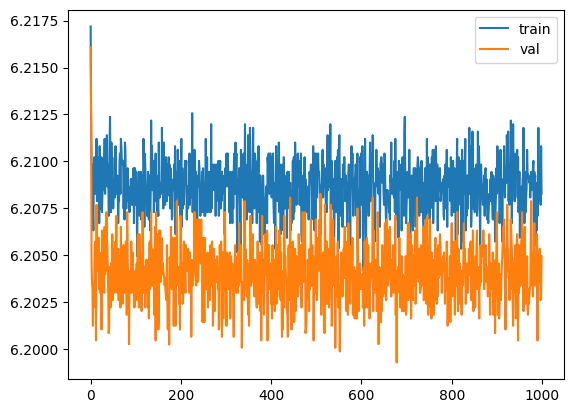

In [67]:
pd.DataFrame(losses).plot()

In [68]:
model.cpu()
x_train,_ = get_batches(dataset,"train",batch_size=1,context_window=CONTEXT_SIZE)
x_val,_ = get_batches(dataset,"val",batch_size=1,context_window=CONTEXT_SIZE)

print(x_train[0])
print(sp.decode(x_train[0].tolist()))
pred_sentence = model.generate(x_train[:,:5],max_new_tokens=32)
print(sp.decode(pred_sentence.tolist()[0]))

tensor([ 61, 451, 285,  68, 469, 475, 464, 154, 459,  78,  33, 463, 465, 447,
         37, 103, 117, 458,  46,  89, 450,  30, 479,  71, 244, 115, 265, 459,
        131,  62, 460, 150])
le,-- BRUTUS: Mark'd you his lip and eyes? SICINIUS: Nay. but
le,-- BR I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I
